In [2]:
#importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime

In [4]:
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error

In [5]:
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [6]:
df=pd.read_excel('C:\\Users\\SHAIK.RIYAZ\\Downloads\\archive\\online_retail_II.xlsx', sheet_name = ["Year 2009-2010", "Year 2010-2011"])
#https://docs.google.com/spreadsheets/d/1R9CSFy97J0RyDkyToBRYtepE7VTahhWp/edit?usp=sharing&ouid=111857456549355039372&rtpof=true&sd=true
#the data is stored in dictionary format so we convert into the dataframe

In [154]:
print(df)

{'Year 2009-2010':        Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-

In [155]:
#to retrive both the sheets of the excel file by passing into variables
df1=df["Year 2009-2010"]
df2=df["Year 2010-2011"]

In [156]:
#combining the both the sheets to convert dictionary into tablular format
data=df1.append(df2)

In [158]:
data['Customer ID'].fillna(11111.0,inplace=True)
data['Description'].fillna("not available",inplace=True)

In [159]:
#removing the negative values(Price)
data=data.loc[data.Price > 0,:]
import scipy.stats as stats
#find Q1, Q3, and interquartile range for each column to remove the outliers for good avg.
Q1 = data['Price'].quantile(q=.25)
Q3 = data['Price'].quantile(q=.75)
IQR = data['Price'].apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data=data.loc[data.Price <= (Q3+1.5*IQR),:]

<AxesSubplot:xlabel='Price'>

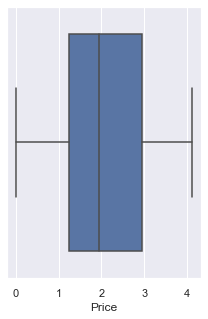

In [478]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(data["Price"])

In [160]:
#removing the negative values(Quantity)
data=data.loc[data.Quantity > 0,:]
import scipy.stats as stats
#find Q1, Q3, and interquartile range for each column to remove the outliers for good avg.
Q1 = data['Quantity'].quantile(q=.25)
Q3 = data['Quantity'].quantile(q=.75)
IQR = data['Quantity'].apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data=data.loc[data.Quantity <= (Q3+1.5*IQR),:]

<AxesSubplot:xlabel='Quantity'>

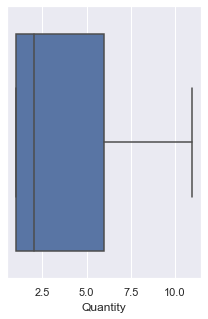

In [479]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(data["Quantity"])

In [282]:
print(max(Q3+1.5*IQR))
print(data)

2.060000333526933
       Invoice StockCode                        Description  Quantity  \
21      489436     22107                 PIZZA PLATE IN BOX         4   
27      489436     21333                CLASSIC WHITE FRAME         6   
28      489436    84596F       SMALL MARSHMALLOWS PINK BOWL         8   
29      489436    84596L     BISCUITS SMALL BOWL LIGHT BLUE         8   
31      489437     22143  CHRISTMAS CRAFT HEART DECORATIONS         6   
...        ...       ...                                ...       ...   
541898  581587     22727          ALARM CLOCK BAKELIKE RED          4   
541899  581587     22726         ALARM CLOCK BAKELIKE GREEN         4   
541900  581587     22730         ALARM CLOCK BAKELIKE IVORY         4   
541901  581587     22367    CHILDRENS APRON SPACEBOY DESIGN         8   
541905  581587     22899       CHILDREN'S APRON DOLLY GIRL          6   

               InvoiceDate  Price  Customer ID         Country  Total Amount  
21     2009-12-01 09:06:00

In [162]:
#identifing the count of null values in each attribute
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [163]:
#removing null values in the data
#axis=0 represents the traversing through row
#axis=1 represents the traversing through column
data.dropna(axis=0,subset=["Description","Customer ID"],inplace=True)

In [164]:
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [165]:
#since we should not perform operations on original data we create a copy
temp_data=data.copy()

In [166]:
#Date Time Analysis
# (i.e) dividing the date into different forms.
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek


In [167]:
#Mapping day of week
#inserting days of week.
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [168]:
#renaming the data values using map function
#assigning the values of dayofweek dictionary.
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [169]:
temp_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Time,Year,Day,Quarter,Day of Week
21,489436,22107,PIZZA PLATE IN BOX,4,2009-12-01 09:06:00,3.75,13078.0,United Kingdom,12,09:06:00,2009,1,4,Tuesday
27,489436,21333,CLASSIC WHITE FRAME,6,2009-12-01 09:06:00,2.95,13078.0,United Kingdom,12,09:06:00,2009,1,4,Tuesday
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom,12,09:06:00,2009,1,4,Tuesday
29,489436,84596L,BISCUITS SMALL BOWL LIGHT BLUE,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom,12,09:06:00,2009,1,4,Tuesday
31,489437,22143,CHRISTMAS CRAFT HEART DECORATIONS,6,2009-12-01 09:08:00,2.10,15362.0,United Kingdom,12,09:08:00,2009,1,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541898,581587,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09 12:50:00,3.75,12680.0,France,12,12:50:00,2011,9,4,Friday
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09 12:50:00,3.75,12680.0,France,12,12:50:00,2011,9,4,Friday
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France,12,12:50:00,2011,9,4,Friday
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France,12,12:50:00,2011,9,4,Friday


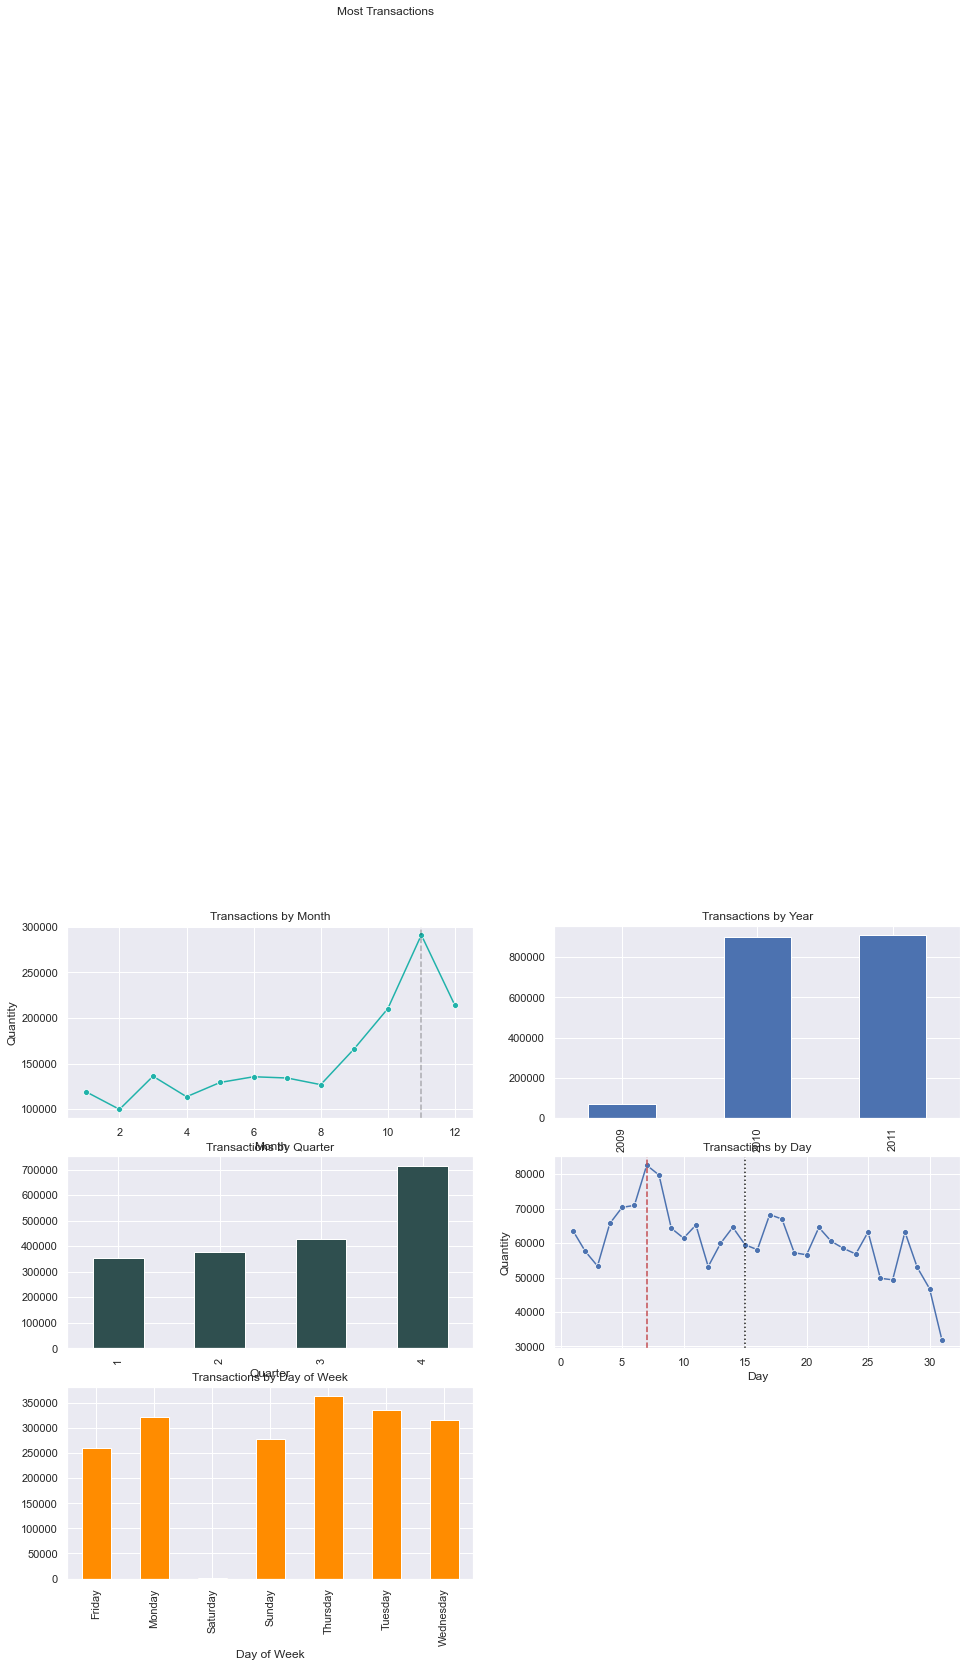

In [170]:
#Plotting the above data
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)#if not used all plots will be represented in a single graph
sns.lineplot(x = "Month", y = "Quantity", data = temp_data.groupby("Month").sum("Quantity"), marker = "o", color = "lightseagreen")
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")
plt.subplot(3,2,2)
temp_data.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Year")
plt.subplot(3,2,3)
temp_data.groupby("Quarter").sum()["Quantity"].plot(kind = "bar", color = "darkslategrey")
plt.title("Transactions by Quarter")
plt.subplot(3,2,4)
sns.lineplot(x = "Day", y = "Quantity", data = temp_data.groupby("Day").sum("Quantity"), marker = "o", )
plt.axvline(7, color = 'r', linestyle = '--')
plt.axvline(15, color = 'k', linestyle = "dotted")
plt.title("Transactions by Day")
plt.subplot(3,2,5)
temp_data.groupby("Day of Week").sum()["Quantity"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")
plt.tight_layout()
plt.show()

In [446]:
data["Total Amount"] = data["Quantity"]*data["Price"]
#calculating the recency, frequency, T, monetary_value
summary = lifetimes.utils.summary_data_from_transaction_data(data, "Customer ID", "InvoiceDate", "Total Amount")
summary = summary.reset_index() #resetting the index
summary.shape

(5356, 5)

In [447]:
summary

,Customer ID,frequency,recency,T,monetary_value
0,11111.0,541.0,738.0,738.0,1201.414621
1,12346.0,1.0,74.0,721.0,3.250000
2,12347.0,7.0,402.0,404.0,145.302857
3,12348.0,0.0,0.0,438.0,0.000000
4,12349.0,2.0,571.0,589.0,276.070000
...,...,...,...,...,...
5351,18283.0,18.0,655.0,658.0,125.905000
5352,18284.0,0.0,0.0,431.0,0.000000
5353,18285.0,0.0,0.0,660.0,0.000000
5354,18286.0,1.0,247.0,723.0,303.400000


In [448]:
c=0
for i in range(len(summary['monetary_value'])):
    if(summary.iloc[i,4]<0):
        summary.iloc[i,4]=0
        c+=1
print(c)
summary['monetary_value'].dropna(inplace=True)

0


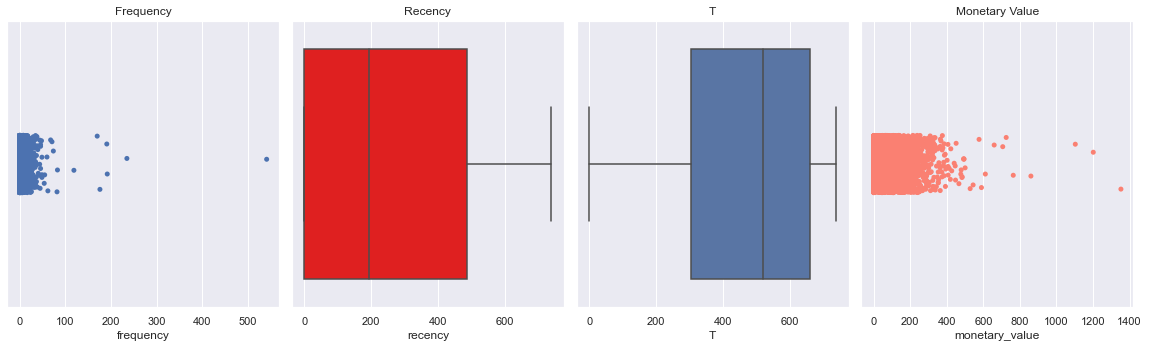

In [449]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.stripplot(summary["frequency"])
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(summary["recency"],color="red")
plt.title("Recency")
plt.subplot(143)
sns.boxplot(summary["T"])
plt.title("T")
plt.subplot(144)
sns.stripplot(summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

In [450]:
#applying the classification model
summary_bgf = summary.copy()
summary_bgf.head(2)

,Customer ID,frequency,recency,T,monetary_value
0,11111.0,541.0,738.0,738.0,1201.414621
1,12346.0,1.0,74.0,721.0,3.250000


count    5356.00000
mean        4.01755
std        11.38225
min         0.00000
25%         0.00000
50%         1.00000
75%         5.00000
max       541.00000
Name: frequency, dtype: float64
Percentage of customers purchase the item only once : 31.42 %


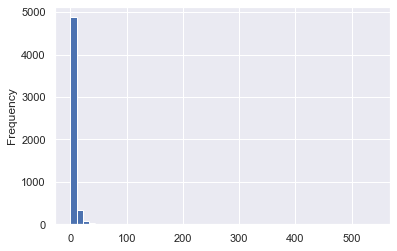

In [451]:
#Create a distribution of frequency to understand the customer frequency level
summary_bgf['frequency'].plot(kind='hist',bins=50)
print(summary_bgf['frequency'].describe())
one_time_buyers=round(sum(summary['frequency']==0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once :", one_time_buyers,"%")

In [452]:
#Fitting the BG/NBD model
#generally there r different models to calculate the CLV.
#here we use the BETAGEO(BG) model for CLV calculation.
bgf=lifetimes.BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary_bgf['frequency'],summary_bgf['recency'],summary_bgf['T'])

<lifetimes.BetaGeoFitter: fitted with 5356 subjects, a: 0.02, alpha: 58.22, b: 0.21, r: 0.53>

In [453]:
#Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.530936,0.011611,0.508178,0.553693
alpha,58.220936,1.813158,54.667148,61.774725
a,0.018580,0.002429,0.013819,0.023342
b,0.206523,0.020688,0.165975,0.247071


In [454]:
#Compute the customer alive probability
#prob(whether our customer is alive or not).
summary_bgf['probability_alive']=bgf.conditional_probability_alive(summary['frequency'],summary['recency'],summary['T'])
summary_bgf.head(10)

,Customer ID,frequency,recency,T,monetary_value,probability_alive
0,11111.0,541.0,738.0,738.0,1201.414621,0.999966
1,12346.0,1.0,74.0,721.0,3.250000,0.423775
2,12347.0,7.0,402.0,404.0,145.302857,0.996916
3,12348.0,0.0,0.0,438.0,0.000000,1.000000
4,12349.0,2.0,571.0,589.0,276.070000,0.983730
5,12350.0,0.0,0.0,310.0,0.000000,1.000000
6,12351.0,0.0,0.0,375.0,0.000000,1.000000
7,12352.0,7.0,356.0,392.0,38.490000,0.994424
8,12353.0,1.0,204.0,408.0,29.300000,0.821611
9,12354.0,0.0,0.0,232.0,0.000000,1.000000


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

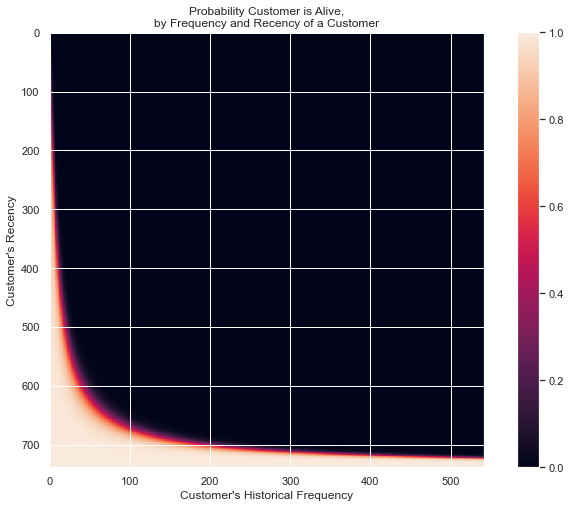

In [455]:
#Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig=plt.figure(figsize =(12,8))
plot_probability_alive_matrix(bgf)

In [456]:
# calculating the prediction of number of transactions for the next 30 days 
t=365
summary_bgf['pred_num_txn']=round(bgf.conditional_expected_number_of_purchases_up_to_time(t,summary_bgf['frequency'],summary_bgf['recency'],summary_bgf['T']))
summary_bgf.sort_values(by='pred_num_txn',ascending=False).head(5000).reset_index()

,index,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,0,11111.0,541.0,738.0,738.0,1201.414621,0.999966,247.0
1,2305,14911.0,235.0,737.0,738.0,187.095915,0.999893,108.0
2,4952,17841.0,192.0,736.0,737.0,170.819427,0.999876,88.0
3,2671,15311.0,191.0,738.0,738.0,56.833455,0.999902,87.0
4,2032,14606.0,176.0,735.0,736.0,80.965852,0.999868,81.0
...,...,...,...,...,...,...,...,...
4995,1047,13522.0,0.0,0.0,30.0,0.000000,1.000000,NaN
4996,1055,13532.0,0.0,0.0,33.0,0.000000,1.000000,NaN
4997,1079,13560.0,0.0,0.0,7.0,0.000000,1.000000,NaN
4998,1087,13568.0,0.0,0.0,173.0,0.000000,1.000000,NaN


In [457]:
#Checking the relationship between frequency and monetary_value
return_customers_summary = summary_bgf[summary_bgf['frequency']>0]
return_customers_summary=return_customers_summary[return_customers_summary['monetary_value']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(3673, 7)


,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,11111.0,541.0,738.0,738.0,1201.414621,0.999966,247.0
1,12346.0,1.0,74.0,721.0,3.250000,0.423775,0.0
2,12347.0,7.0,402.0,404.0,145.302857,0.996916,6.0
4,12349.0,2.0,571.0,589.0,276.070000,0.983730,1.0
7,12352.0,7.0,356.0,392.0,38.490000,0.994424,6.0


In [458]:
#Checking the relationship between frequency and monetary_value
return_customers_summary[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.200039
monetary_value,0.200039,1.000000


In [459]:
#Modeling the monetary value using Gamma-Gamma Model
#where gamma-gamma model is a part of BG model.
ggf=lifetimes.GammaGammaFitter(penalizer_coef=0.000)
ggf.fit(return_customers_summary['frequency'],return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 3673 subjects, p: 1.56, q: 4.01, v: 217.07>

In [460]:
#Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.558833,0.073664,1.414451,1.703214
q,4.014999,0.171589,3.678683,4.351314
v,217.066398,19.124435,179.582506,254.550289


In [461]:
#Calculating the conditional expected average profit for each customer per transaction
summary_bgf = summary_bgf[summary_bgf['monetary_value']>0]
summary_bgf['exp_avg_sales']=ggf.conditional_expected_average_profit(summary_bgf['frequency'],summary_bgf['monetary_value'])
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
0,11111.0,541.0,738.0,738.0,1201.414621,0.999966,247.0,1197.534526
1,12346.0,1.0,74.0,721.0,3.250000,0.423775,0.0,75.087245
2,12347.0,7.0,402.0,404.0,145.302857,0.996916,6.0,138.142739
4,12349.0,2.0,571.0,589.0,276.070000,0.983730,1.0,195.520911
7,12352.0,7.0,356.0,392.0,38.490000,0.994424,6.0,54.453642


In [462]:
#Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary_bgf['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary_bgf['monetary_value'].mean()}")

Expected Average Sales: 111.11173540774855
Actual Average Sales: 105.87995915604048


In [463]:
#Predicting Customer Lifetime Value for the next 30 days
summary_bgf['predicted_clv']= ggf.customer_lifetime_value(bgf,summary_bgf['frequency'],summary_bgf['recency'],summary_bgf['T'],summary_bgf['monetary_value'],time=1,freq='D',discount_rate=0.01)
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
0,11111.0,541.0,738.0,738.0,1201.414621,0.999966,247.0,1197.534526,24183.111160
1,12346.0,1.0,74.0,721.0,3.250000,0.423775,0.0,75.087245,1.855596
2,12347.0,7.0,402.0,404.0,145.302857,0.996916,6.0,138.142739,66.601553
4,12349.0,2.0,571.0,589.0,276.070000,0.983730,1.0,195.520911,22.325795
7,12352.0,7.0,356.0,392.0,38.490000,0.994424,6.0,54.453642,26.885121


In [464]:
#CLV in terms of profit (profit margin is 5%)
profit_margin=0.05
summary_bgf['CLV']=summary_bgf['predicted_clv']*profit_margin
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,CLV
0,11111.0,541.0,738.0,738.0,1201.414621,0.999966,247.0,1197.534526,24183.111160,1209.155558
1,12346.0,1.0,74.0,721.0,3.250000,0.423775,0.0,75.087245,1.855596,0.092780
2,12347.0,7.0,402.0,404.0,145.302857,0.996916,6.0,138.142739,66.601553,3.330078
4,12349.0,2.0,571.0,589.0,276.070000,0.983730,1.0,195.520911,22.325795,1.116290
7,12352.0,7.0,356.0,392.0,38.490000,0.994424,6.0,54.453642,26.885121,1.344256


In [465]:
#Distribution of CLV for the business in the next 1 year
summary_bgf['CLV'].describe()

count    3.673000e+03
mean     2.147584e+00
std      2.035643e+01
min      4.561417e-09
25%      4.862263e-01
50%      9.701759e-01
75%      2.060000e+00
max      1.209156e+03
Name: CLV, dtype: float64

In [466]:
k=summary_bgf['Customer ID'].groupby(summary_bgf['CLV'])

In [467]:
print(summary_bgf)

      Customer ID  frequency  recency      T  monetary_value  \
0         11111.0      541.0    738.0  738.0     1201.414621   
1         12346.0        1.0     74.0  721.0        3.250000   
2         12347.0        7.0    402.0  404.0      145.302857   
4         12349.0        2.0    571.0  589.0      276.070000   
7         12352.0        7.0    356.0  392.0       38.490000   
...           ...        ...      ...    ...             ...   
5349      18281.0        1.0    397.0  577.0       31.800000   
5350      18282.0        1.0    119.0  126.0       30.700000   
5351      18283.0       18.0    655.0  658.0      125.905000   
5354      18286.0        1.0    247.0  723.0      303.400000   
5355      18287.0        4.0    513.0  571.0       53.100000   

      probability_alive  pred_num_txn  exp_avg_sales  predicted_clv  \
0              0.999966         247.0    1197.534526   24183.111160   
1              0.423775           0.0      75.087245       1.855596   
2              0.9

In [468]:
print(summary_bgf['CLV'].median())#represents the Q2.
summary_bgf1=summary_bgf.copy()

0.9701758554595337


In [469]:
import scipy.stats as stats
#find Q1, Q3, and interquartile range for each column to remove the outliers for good avg.
Q1 = summary_bgf['CLV'].quantile(q=.25)
Q3 = summary_bgf['CLV'].quantile(q=.75)
IQR = summary_bgf['CLV'].apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
#summary_bgf['CLV'] = summary_bgf['CLV'][~((summary_bgf['CLV'] < (Q1-1.5*IQR)) | (summary_bgf['CLV'] > (Q3+1.5*IQR)))]

In [470]:
clv=np.mean(summary['frequency'])
print(clv)
summary_bgf['CLV'].fillna(clv,axis=0,inplace=True)

4.0175504107542945


In [490]:
# creating a column LABEL to represent the clv range as following.
m=max(Q3+1.5*IQR)
print(m)
summary_bgf['Label']="low"
l=summary_bgf['CLV'].tolist()
for i in range(len(summary_bgf1['Customer ID'])):
    if(summary_bgf.iloc[i,9] <= m * 0.2):
        summary_bgf.iloc[i,10]="low"
    elif(summary_bgf.iloc[i,9] >= m * 0.9 ):
        summary_bgf.iloc[i,10]="high"
    else:
        summary_bgf.iloc[i,10]="medium"

2.060000333526933


In [491]:
print(summary_bgf.head(50))

    Customer ID  frequency  recency      T  monetary_value  probability_alive  \
0       11111.0      541.0    738.0  738.0     1201.414621           0.999966   
1       12346.0        1.0     74.0  721.0        3.250000           0.423775   
2       12347.0        7.0    402.0  404.0      145.302857           0.996916   
4       12349.0        2.0    571.0  589.0      276.070000           0.983730   
7       12352.0        7.0    356.0  392.0       38.490000           0.994424   
8       12353.0        1.0    204.0  408.0       29.300000           0.821611   
10      12355.0        1.0    353.0  567.0       53.100000           0.854070   
11      12356.0        3.0    179.0  424.0       50.770000           0.906547   
12      12357.0        1.0    355.0  388.0      167.100000           0.908103   
13      12358.0        3.0    581.0  731.0       61.333333           0.982583   
14      12359.0        8.0    677.0  734.0      212.836250           0.995149   
15      12360.0        5.0  

Text(0.5, 1.0, 'future 1 year customer lifetime value')

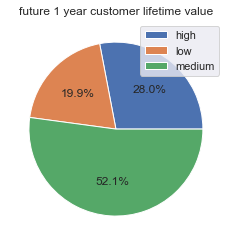

In [492]:
#FINAL RESULT TO PREDICT THE 1 year ANALYSIS.
plt.pie(summary_bgf['Customer ID'].groupby(summary_bgf['Label']).sum(),autopct='%1.1f%%')
plt.legend(['high','low','medium'])
plt.title("future 1 year customer lifetime value")

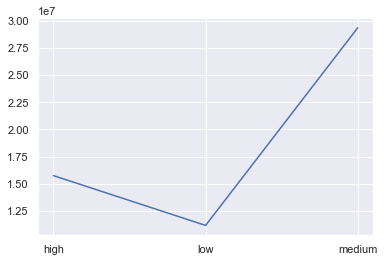

In [493]:
plt.plot(summary_bgf['Customer ID'].groupby(summary_bgf['Label']).sum())

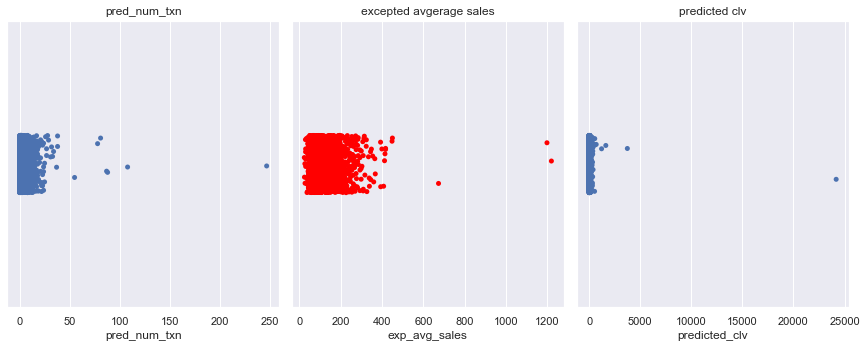

In [494]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.stripplot(summary_bgf["pred_num_txn"])
plt.title("pred_num_txn")
plt.subplot(142)
sns.stripplot(summary_bgf["exp_avg_sales"],color="red")
plt.title("excepted avgerage sales")
plt.subplot(143)
sns.stripplot(summary_bgf["predicted_clv"])
plt.title("predicted clv")
plt.tight_layout()